<a href="https://colab.research.google.com/github/KandarpChaudhary/CIFAR-10-Image-Classifier/blob/main/D21016_CIFAR_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Kandarp Chaudhary
# Roll No.: D21016

# CIFAR  with CNN
The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck



## Perform standard imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

## Load the CIFAR-10 dataset
PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Doing train-validation split
from torch.utils.data import random_split
val_size = 5000
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
# Loading batches of train and validation data

from torch.utils.data.dataloader import DataLoader
batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

## <div class="alert alert-info"><strong>Why <tt>(256x4x4) as input of first Fully Connected Layer</tt>?</strong><br>
> With CIFAR the result is $\;((32/2)/2)/2 = 4\;$ which means 4 pixels per side after 3 maxpooling layers.</div>

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader,epochs=10,learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), 'cifar10-cnn.pth')
        history.append(result)
    return history

In [ ]:
# defining model object
model = Cifar10CnnModel()

In [ ]:
# training the model
history = fit(model, train_dl, val_dl)

100%|██████████| 704/704 [12:39<00:00,  1.08s/it]


Epoch : 1
Train Accuracy:54.44% Validation Accuracy:66.85%
Train Loss:1.2726 Validation Loss:0.9302


100%|██████████| 704/704 [11:58<00:00,  1.02s/it]


Epoch : 2
Train Accuracy:71.48% Validation Accuracy:70.89%
Train Loss:0.8212 Validation Loss:0.8678


100%|██████████| 704/704 [12:08<00:00,  1.03s/it]


Epoch : 3
Train Accuracy:77.28% Validation Accuracy:71.30%
Train Loss:0.6651 Validation Loss:0.8686


100%|██████████| 704/704 [12:31<00:00,  1.07s/it]


Epoch : 4
Train Accuracy:80.48% Validation Accuracy:76.60%
Train Loss:0.5719 Validation Loss:0.6801


100%|██████████| 704/704 [16:24<00:00,  1.40s/it]


Epoch : 5
Train Accuracy:83.16% Validation Accuracy:77.41%
Train Loss:0.4889 Validation Loss:0.6857


100%|██████████| 704/704 [18:39<00:00,  1.59s/it]


Epoch : 6
Train Accuracy:84.78% Validation Accuracy:78.68%
Train Loss:0.4393 Validation Loss:0.6422


100%|██████████| 704/704 [19:56<00:00,  1.70s/it]


Epoch : 7
Train Accuracy:86.48% Validation Accuracy:79.03%
Train Loss:0.3888 Validation Loss:0.6748


100%|██████████| 704/704 [20:44<00:00,  1.77s/it]


Epoch : 8
Train Accuracy:87.74% Validation Accuracy:79.17%
Train Loss:0.3610 Validation Loss:0.6356


100%|██████████| 704/704 [19:09<00:00,  1.63s/it]


Epoch : 9
Train Accuracy:88.72% Validation Accuracy:79.02%
Train Loss:0.3272 Validation Loss:0.6721


100%|██████████| 704/704 [23:01<00:00,  1.96s/it]


Epoch : 10
Train Accuracy:89.56% Validation Accuracy:80.95%
Train Loss:0.3039 Validation Loss:0.6065


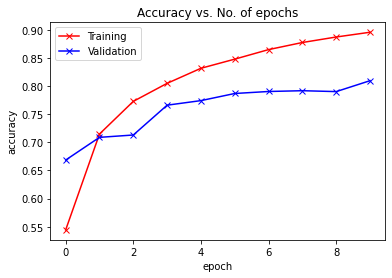

In [ ]:
# Plotting Accuracy vs. No. of epochs for training and testing data
def plot_accuracies(history):
    Validation_accuracies = [x['Accuracy'] for x in history]
    Training_Accuracies = [x['train_accuracy'] for x in history]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

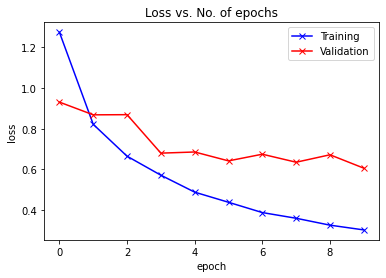

In [ ]:
# Plotting Loss vs. No. of epochs for training and testing data
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['Loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
test_loader = DataLoader(test_data, batch_size)
result = evaluate(model, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')

Test Accuracy:82.24%


## Conclusion: 
> Here, with 10 epochs, I achieved an accuracy of 89.56% by using 6 convolution layers, 3 maxpooling layers, 3 batch normalizing layers, 3 fully connected layers and 2 dropout regularizations. The accuracy for validation dataset was 80.95%. This is in increasing trend, so with higher number of epochs, I could have gotten better train and validation accuracies but due to resource and time constraints, I could not run it for more epochs. The accuracy for test dataset is 82.24%, which is far better than any random guess accuracy of 10% for this dataset.